# Research links

1) ZFNet: https://medium.com/coinmonks/paper-review-of-zfnet-the-winner-of-ilsvlc-2013-image-classification-d1a5a0c45103
2) Reverse Autoencoder: https://openaccess.thecvf.com/content_WACV_2020/papers/Lydia_Reverse_Variational_Autoencoder_for_Visual_Attribute_Manipulation_and_Anomaly_Detection_WACV_2020_paper.pdf
   1) I wanted to find some kind of reverse loss function calculations

In [195]:
import torch
import torchvision
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch, gc

# Flush GPU memory, and garbadge collector

My GPU is always full, idk why but the jupyter kernel doesn't release the memory. So each run I flush the memory.

In [196]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
TRAIN_BATCH_SIZE = 256

# Load datasets

In [197]:
train_data_transformed = torchvision.datasets.MNIST(root="/MNIST", train=True, download=True, transform=torchvision.transforms.ToTensor())

train_dataloader = DataLoader(train_data_transformed, batch_size=TRAIN_BATCH_SIZE)
img, _ = next(iter(train_dataloader))

# Check GPU

In [198]:
if torch.cuda.is_available():
	device = torch.device('cuda:0')
	print("Using GPU")
else:
	device = torch.device('cpu')
	print("Using CPU")

Using GPU


# Activations for encoder and decoder reasons

We use sigmoid activation for the decoder, which outputs the final image (neurons), because it normalizes the neurons to be between 0 and 1.

We use ReLU activation for the encoder, in order to give the model 'more freedom' to change the values, and use real numbers instead of natural numbers for finer control over the weights.

# Autoencoder diagram for loss function

<![autoencoder diagram and its loss function calculation](./imgs/diagram.png)>

# Constants

In [199]:
# Train parameters
IMAGE_SIZE = [28, 28]
TRAIN_BATCH_SIZE = 256
TRAIN_EPOCHS = 5

# Weights used in calculation of loss function
# The weights are not bound (between [0,1] and0 [0,100] for example), but relative to each other
HIDDEN_LOSS_WEIGHT_INNER = 15
HIDDEN_LOSS_WEIGHT_OUTSIDE = 15
OUTPUT_LOSS_WEIGHT = 70  # Output weight should have very high value, because its the most important loss.

# The dimension of the hidden layers
BOTTLENECK_DIM_1 = 392
BOTTLENECK_DIM_2 = 196
BOTTLENECK_DIM_3 = 98

In [200]:
# Aggregate loss between layers
hidden_loss_inner = []
hidden_loss_outside = []

I put encoder and decoder together so that I don't need to save in memory both layers. This is more efficient.

In [201]:
class MyAutoencoder(nn.Sequential):
	def __init__(self):
		super().__init__()
		# Encoder
		self.e_linear1 = nn.Linear(IMAGE_SIZE[0] * IMAGE_SIZE[1], BOTTLENECK_DIM_1)
		self.e_linear2 = nn.Linear(BOTTLENECK_DIM_1, BOTTLENECK_DIM_2)
		self.e_bottleneck = nn.Linear(BOTTLENECK_DIM_2, BOTTLENECK_DIM_3)
		self.relu = nn.ReLU()

		# Decoder
		self.d_bottleneck = nn.Linear(BOTTLENECK_DIM_3, BOTTLENECK_DIM_2)
		self.d_linear2 = nn.Linear(BOTTLENECK_DIM_2, BOTTLENECK_DIM_1)
		self.d_linear1 = nn.Linear(BOTTLENECK_DIM_1, IMAGE_SIZE[0] * IMAGE_SIZE[1])
		self.sigmoid = nn.Sigmoid()

		self.to(device)

	def forward(self, image: torch.Tensor) -> torch.Tensor:
		# Encoder
		e_lin1 = self.e_linear1(image.flatten(start_dim=1))
		e_lin2 = self.e_linear2(e_lin1)
		e_bottleneck = self.e_bottleneck(e_lin2)
		e_output = self.relu(e_bottleneck)  # Encoder output

		# Decoder
		d_bottleneck = self.d_bottleneck(e_output)
		d_lin2 = self.d_linear2(d_bottleneck)
		d_lin1 = self.d_linear1(d_lin2)
		d_output = self.sigmoid(d_lin1)

		res = d_output.reshape(-1, 1, IMAGE_SIZE[0], IMAGE_SIZE[1])

		# Loss calculation
		_hidden_loss_inner = HIDDEN_LOSS_WEIGHT_INNER * nn.MSELoss()(e_lin2, - (d_bottleneck))  # NOTICE THE MINUS.
		_hidden_loss_outer = HIDDEN_LOSS_WEIGHT_OUTSIDE * nn.MSELoss()(e_lin1, -(d_lin2)) # NOTICE THE MINUS.
		_output_loss = OUTPUT_LOSS_WEIGHT * nn.MSELoss()(image, res)
		_hidden_loss = _hidden_loss_inner + _hidden_loss_outer
		loss = _hidden_loss + _output_loss

		hidden_loss_inner.append(_hidden_loss_inner.detach().cpu())
		hidden_loss_outside.append(_hidden_loss_outer.detach().cpu())

		return res, loss

# What does autoencoder mean for this assignment

It means that we compress the image to lower dimension, and then try best to reconstruct it back to higher dimension.

This 'streching' allows for data compression, because nearest neighbours of the source pixels is simillar as a group, less sharp, which allows for greater compression. Instead of using complicated mathenatics to accuracly compress the image, we can sue this instead.

What the professor tries to achieve, I think, it a method to compress and then decompress the image.

In [202]:
autoencoder = MyAutoencoder()
optimizer = torch.optim.AdamW(autoencoder.parameters())
loss_func = nn.MSELoss()

# Train the model

In [203]:
def iterate_batch(imgs):
	imgs = imgs.to(device)
	optimizer.zero_grad()
	_, loss = autoencoder(imgs)
	loss.backward()
	optimizer.step()
	return loss

In [211]:
batches=len(train_dataloader)

batch_loss=torch.empty(batches,device=device)
epoch_loss=torch.empty(TRAIN_EPOCHS,device=device)
for epoch_idx in tqdm(range(TRAIN_EPOCHS)):
	for batch_idx, (imgs, _) in enumerate(train_dataloader):
		batch_loss[batch_idx] = iterate_batch(imgs)
	with torch.no_grad():
		epoch_loss[epoch_idx]=batch_loss.mean()

100%|██████████| 5/5 [01:40<00:00, 20.07s/it]


# Plot loss

We want to see loss approaching zero.

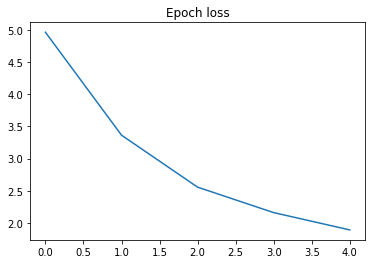

In [205]:
plt.title("Epoch loss")
plt.plot(epoch_loss[:epoch_idx+1].cpu().detach());

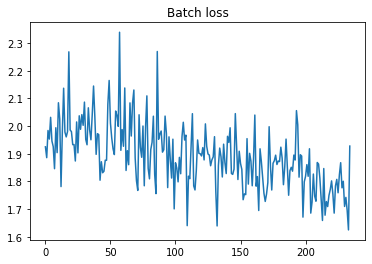

In [206]:
plt.title("Batch loss")
plt.plot(batch_loss.cpu().detach());

# Show some images before and after autoencoder

In [207]:
imgs, _ = next(iter(train_dataloader))

# Plot reconstructed images

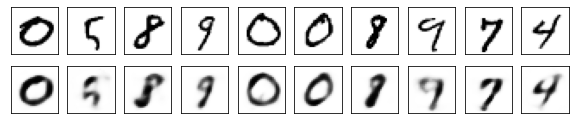

In [208]:
num_images=10
with torch.no_grad():
	reconstructed, loss = autoencoder(imgs.to(device))
	reconstructed = reconstructed.cpu().detach()
	
	fig,axes = plt.subplots(2,num_images,sharey=True)
	fig.set_figheight(2)
	fig.set_figwidth(10)
	rand_idx=torch.randint(size=(num_images,),high=imgs.size(0))
	for idx in range(num_images):
		axes[0,idx].imshow(imgs[rand_idx[idx],...].reshape(28,28).detach(),cmap='Greys')
		axes[0,idx].axes.get_xaxis().set_visible(False)
		axes[0,idx].axes.get_yaxis().set_visible(False)

		axes[1,idx].imshow(reconstructed[[rand_idx[idx]],...].reshape(28,28).detach(),cmap='Greys')
		axes[1,idx].axes.get_xaxis().set_visible(False)
		axes[1,idx].axes.get_yaxis().set_visible(False)


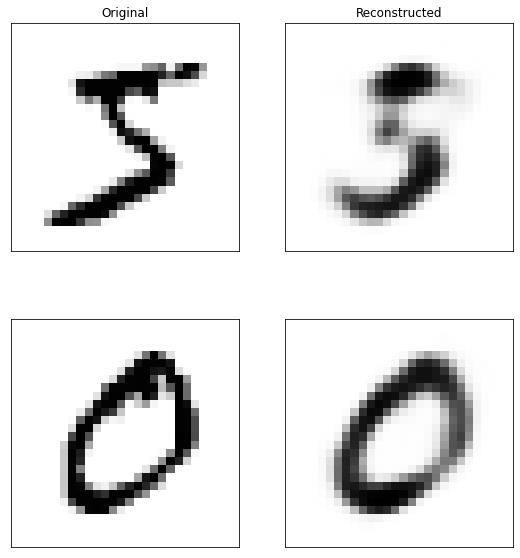

In [209]:
num_images=2
with torch.no_grad():
	reconstructed, loss = autoencoder(imgs.to(device))
	reconstructed = reconstructed.cpu().detach()
	
	fig,axes = plt.subplots(num_images,2)
	fig.set_figheight(10)
	fig.set_figwidth(9)
	for idx in range(num_images):
		axes[idx,0].imshow(imgs[idx,...].reshape(28,28).detach(),cmap='Greys')
		axes[idx,0].axes.get_xaxis().set_visible(False)
		axes[idx,0].axes.get_yaxis().set_visible(False)
    
		axes[idx,1].imshow(reconstructed[idx,...].reshape(28,28).detach(),cmap='Greys')
		axes[idx,1].axes.get_xaxis().set_visible(False)
		axes[idx,1].axes.get_yaxis().set_visible(False)
axes[0,0].set_title("Original");
axes[0,1].set_title("Reconstructed");

# Section D - Compare layers

As we can see, the model tries to achieve the transpose of each hidden layer.

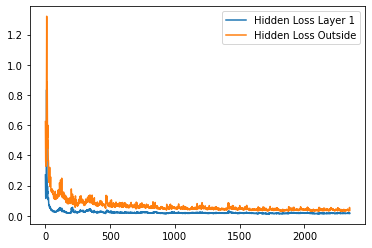

In [212]:
plt.plot(hidden_loss_inner, label="Hidden Loss Layer 1");
plt.plot(hidden_loss_outside, label="Hidden Loss Outside");

plt.legend();